<a href="https://colab.research.google.com/github/isaranga/EFIM/blob/master/EFIM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title class Transaction

class Transaction:
    """
    A class representing a single transaction of a dataset.
    """

    offset: int = 0
    prefix_utility: int = 0

    def __init__(self, items: list, trans_utility: int, utilities: list) -> None:
        self.items: list = items
        self.transaction_utility: int = trans_utility
        self.utilities: list = utilities

    def __repr__(self) -> str:
        return f"Transaction({self.items}, {self.transaction_utility}, {self.utilities})"

    def rename_items(self, old_names_to_new_name: dict) -> None:
        """This method renames items from their old name to the new name obtained by the sort method"""
        temp_items = []
        temp_utilities = []

        for idx, item in enumerate(self.items):
            temp_items.append(old_names_to_new_name[item])
            temp_utilities.append(self.utilities[idx])

        self.items = temp_items
        self.utilities = temp_utilities

        # Sort by increasing values
        self.insertion_sort()

    def remove_unpromising_items(self, promising_items: list) -> None:
        """This method removes unpromising items from the transaction."""
        temp_items = []
        temp_utilities = []

        for idx, item in enumerate(self.items[self.offset:]):
            # if the item is promising, we keep it and its utility,
            # otherwise we subtract its utility from the transaction utility
            if item in promising_items:
                temp_items.append(item)
                temp_utilities.append(self.utilities[idx+self.offset])
            else:
                self.transaction_utility -= self.utilities[idx+self.offset]

        self.items = temp_items
        self.utilities = temp_utilities

        self.offset = 0

    def insertion_sort(self) -> None:
        """Sorts the items of the transaction by increasing order values (obtained by the sort method)."""
        for i in range(1, len(self.items)):
            key = self.items[i]
            utility_j = self.utilities[i]
            j = i - 1

            while j >= 0 and key < self.items[j]:
                self.items[j + 1] = self.items[j]
                self.utilities[j + 1] = self.utilities[j]
                j -= 1

            self.items[j + 1] = key
            self.utilities[j + 1] = utility_j

    def project_transaction(self, offset_e: int):
        """Creates a new Transaction from this transaction starting from offset until the end."""
        new_transaction = Transaction(self.items, self.transaction_utility, self.utilities)
        utility_e = self.utilities[offset_e]

        # Add the  utility of item e to the utility of the whole prefix used to project the transaction
        new_transaction.prefix_utility = self.prefix_utility + utility_e

        # Calculate the remaining utility.
        # It is the transaction utility minus the profit of the element that was removed
        new_transaction.transaction_utility = self.transaction_utility - utility_e
        # Subtract the utility of all items before e but after the previous offset
        for i in range(self.offset, offset_e):
            new_transaction.transaction_utility -= self.utilities[i]

        new_transaction.offset = offset_e + 1

        return new_transaction


In [ ]:
#@title class Dataset
class Dataset:
    """
    A class representing a list of transactions of a dataset.
    """

    def __init__(self, input_file: str, sep: str = " ", ratio: int = 1) -> None:
        self.input_file: str = input_file
        self.sep: str = sep
        self.ratio: int = ratio

        self.transactions: list = []
        self.str_to_int: dict = {}
        self.int_to_str: dict = {}
        self.cnt: int = 1
        self.max_item: int = 0

        self.create_itemsets(self.input_file)

    def __repr__(self) -> str:
        return f"Dataset({len(self.transactions)} transactions, {len(self.str_to_int)} items, max item={self.max_item})"

    def create_itemsets(self, input_file) -> None:
        """Stores the complete transactions of the database/input file in a database variable."""
        self.transactions = []
        with open(input_file, 'r') as file:
          line_count = sum(1 for line in file)

        max_trans = line_count * self.ratio
        with open(input_file, "r") as file:

            row_num = 0
            for line in file:
                if line.startswith('#'):
                    continue
                if row_num >= max_trans:
                    break
                row_num += 1

                trans_list = line.strip().split(':')
                items_string = trans_list[0].strip().split(self.sep)
                trans_utility = int(trans_list[1])
                utility_string = trans_list[2].strip().split(self.sep)
                transaction = self.create_transaction(items_string, trans_utility, utility_string)
                self.transactions.append(transaction)

    def create_transaction(self, items_string, trans_utility, utility_string) -> Transaction:
        """Creates a transaction object."""
        items = []
        utilities = []

        for idx, item in enumerate(items_string):
            if item not in self.str_to_int:
                self.str_to_int[item] = self.cnt
                self.int_to_str[self.cnt] = item
                self.cnt += 1

            item_int = self.str_to_int[item]

            if item_int > self.max_item:
                self.max_item = item_int

            items.append(item_int)
            utilities.append(int(utility_string[idx]))

        return Transaction(items, trans_utility, utilities)

In [ ]:
#@title Imports
import argparse
import functools
import logging
import os
import sys
import time
from pathlib import Path
from typing import Union
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
try:
    import google.colab

    IN_COLAB = True
except ImportError:
    IN_COLAB = False
print_process = False

#EFIM

In [ ]:
#@title class EFIM
class EFIM:
    def __init__(self, input_file: str, min_util: int, sep: str = " ", output_file: str = "output.txt", logger=None, f_type: str = 'base', ratio: int = 1) -> None:
        self.input_file: str = input_file
        self.min_util: int = min_util
        self.sep: str = sep
        self.output_file = output_file
        self.ratio = ratio

        self._start_time: float = 0.0
        self._end_time: float = 0.0
        self.logger = logger
        self._dataset: Union[Dataset, None] = None
        self._utility_bin_array_LU: dict = {}
        self._utility_bin_array_SU: dict = {}
        self._old_names_to_new_names: dict = {}
        self._new_names_to_old_names: dict = {}
        self._candidate_count: int = 0
        self._temp: list[int] = [0] * 5000
        self._pattern_count: int = 0
        self._final_patterns: dict = {}
        self.type = f_type

    def run(self) -> None:
        """Starts the EFIM algorithm."""
        self._start_time = time.time()
        self._dataset = Dataset(self.input_file, self.sep, self.ratio)
        self.logger.info(f"Items int to str: {sorted(self._dataset.int_to_str.items())}")

        # Do steps 2-5 of Algorithm 1 in loop
        len_promising = self._dataset.max_item
        while 1:
            self.calculate_local_utilities(self._dataset)  # line 2 of Algorithm 1
            self.logger.info(f"Local utilities. id(original_id): {[str(key) + '(' + self._dataset.int_to_str[key] + '): ' + str(val) for key, val in self._utility_bin_array_LU.items()]}")

            # secondary holds the promising items (those having a TWU >= minutil)
            secondary = [item for item in self._utility_bin_array_LU if self._utility_bin_array_LU[item] >= self.min_util]
            if not len(secondary) < len_promising:
                break

            len_promising = len(secondary)
            for transaction in self._dataset.transactions:
                transaction.remove_unpromising_items(secondary)

            # To get the same algorithm as in the paper, break after 1 run of this loop
            if self.type == 'base':
                break

            # self.logger.info(f"Transactions after removing unpromising items: {self._dataset.transactions}")

        # Sort by the total order of TWU ascending values (line 4 of Algorithm 1)
        secondary = self.sort_method(secondary)
        self.logger.info(f"Secondary (sorted by TWU). name(original_id): {[str(x) + '(' + self._dataset.int_to_str[x] + ')' for x in secondary]}")

        self.rename_promising_items(secondary)
        self.logger.info(f"Renaming (old name, new name): {[self._dataset.int_to_str[x]+':('+str(x)+', '+str(self._old_names_to_new_names[x])+')' for x in sorted(self._old_names_to_new_names, key=lambda x: self._old_names_to_new_names[x])]}")

        for transaction in self._dataset.transactions:
            transaction.rename_items(self._old_names_to_new_names)

        self.sort_dataset(self._dataset.transactions)
        # self.logger.info(f"Transactions after sorting: {self._dataset.transactions}")

        # Remove empty transactions
        empty_transactions_count = len([transaction for transaction in self._dataset.transactions
                                        if not transaction.items])
        # To remove empty transactions, we just ignore the first transactions of the dataset, since transactions
        # are sorted by size and therefore empty transactions are always at the begining of the dataset
        self._dataset.transactions = self._dataset.transactions[empty_transactions_count:]
        self.logger.info(f"{empty_transactions_count} empty transactions removed.")

        # Calculate the subtree utility of each item in secondary using a utility-bin array
        self.calculate_subtree_utility(self._dataset)
        self.logger.info(f"Subtree utilities. new_name(original_id): {[str(key)+'('+self._dataset.int_to_str[self._new_names_to_old_names[key]]+'): '+str(val) for key, val in self._utility_bin_array_SU.items()]}")

        # primary holds items in secondary that have a subtree utility >= minutil
        primary = [item for item in secondary if self._utility_bin_array_SU[item] >= self.min_util]
        self.logger.info(f"Primary: {primary}")

        # Call the recursive Search procedure
        self.search(self._dataset.transactions, secondary, primary, prefix_length=0)

        # the print inside the search() method doesn't print newlines, so we print one here
        print("")

        self._end_time = time.time()
        self.logger.info(f"EFIM algorithm finished in {self._end_time - self._start_time:.2f} seconds.")

    def sort_method(self, secondary):
        # Sort by the total order of TWU ascending values (line 4 of Algorithm 1)
        secondary = sorted(secondary, key=lambda x: self._utility_bin_array_LU[x])
        return secondary

    def rename_promising_items(self, secondary):
        """Rename promising items according to the increasing order of TWU.
        This will allow very fast comparison between items later by the algorithm
        We will give the new names starting from the name '1'."""
        current_name = 1
        for idx, item in enumerate(secondary):
            self._old_names_to_new_names[item] = current_name
            self._new_names_to_old_names[current_name] = item
            secondary[idx] = current_name
            current_name += 1

    def calculate_local_utilities(self, dataset: Dataset) -> None:
        """Calculates the local utilities of all items in the dataset by using utility-bin array."""
        self._utility_bin_array_LU = {}
        for transaction in dataset.transactions:
            for item in transaction.items:
                if item in self._utility_bin_array_LU:
                    self._utility_bin_array_LU[item] += transaction.transaction_utility
                else:
                    self._utility_bin_array_LU[item] = transaction.transaction_utility

    def sort_dataset(self, transactions: list) -> None:
        cmp_items = functools.cmp_to_key(self.compare_transaction)
        transactions.sort(key=cmp_items)

    @staticmethod
    def compare_transaction(trans1: Transaction, trans2: Transaction) -> int:
        """Compares two transactions according to the proposed total order on transaction (the lexicographical
        order when transactions are read backward)"""
        # we will compare the two transaction item by item starting from the last items
        trans1_items = trans1.items
        trans2_items = trans2.items
        pos1 = len(trans1_items) - 1
        pos2 = len(trans2_items) - 1

        if len(trans1_items) < len(trans2_items):
            while pos1 >= 0:
                diff = trans2_items[pos2] - trans1_items[pos1]
                if diff != 0:
                    return diff
                pos1 -= 1
                pos2 -= 1
            return -1

        elif len(trans1_items) > len(trans2_items):
            while pos2 >= 0:
                diff = trans2_items[pos2] - trans1_items[pos1]
                if diff != 0:
                    return diff
                pos1 -= 1
                pos2 -= 1
            return 1

        else:
            while pos2 >= 0:
                diff = trans2_items[pos2] - trans1_items[pos1]
                if diff != 0:
                    return diff
                pos1 -= 1
                pos2 -= 1
            return 0

    def calculate_subtree_utility(self, dataset: Dataset) -> None:
        """Scan the initial dataset to calculate the subtree utility of each item using a utility-bin array"""
        for transaction in dataset.transactions:
            # We will scan the transaction backwards. Thus, the current subtree utility in that transaction is zero
            # for the last item of the transaction.
            sum_SU: int = 0

            i = len(transaction.items) - 1
            while i >= 0:
                item = transaction.items[i]
                sum_SU += transaction.utilities[i]
                if item in self._utility_bin_array_SU.keys():
                    self._utility_bin_array_SU[item] += sum_SU
                else:
                    self._utility_bin_array_SU[item] = sum_SU
                i -= 1

    def search(self, transactions_of_P: list, secondary: list, primary: list, prefix_length: int) -> None:
        """
        Recursive method to find all high-utility itemsets.
        :param transactions_of_P: list of transactions containing the current prefix
        :param secondary: list of secondary items in the projected database
        :param primary: list of primary items in the projected database
        :param prefix_length: length of the current prefix
        """
        # update the number of candidates explored so far
        self._candidate_count += len(primary)
        if print_process:
          print(f"\rRun search, candidate_count: {self._candidate_count}", end='')

        for idx, e in enumerate(primary):  # line 1 of Algorithm 2
            # ========== PERFORM INTERSECTION =====================
            # Calculate transactions containing P U {e}
            # At the same time project transactions to keep what appears after "e"
            transactions_Pe: list[Transaction] = []  # --> beta - D in the paper
            # variable to calculate the utility of P U {e}
            utility_Pe: int = 0  # --> u(beta) in the paper
            # --> scan alpha - D (line 3 of Algorithm 2)
            transactions_Pe, utility_Pe = self.scan_database(e, prefix_length, transactions_Pe, transactions_of_P, utility_Pe)
            # --> line 4 of Algorithm 2
            # if the utility of PU{e} is enough to be a high utility itemset
            if utility_Pe >= self.min_util:
                self._output(prefix_length, utility_Pe)

            # Next, we calculate the Local Utility and Sub-tree utility
            # of all items that could be appended to P U {e}
            e_idx_secondary = secondary.index(e)
            e_secondary = secondary[e_idx_secondary+1:]
            len_promising = len(e_secondary)
            new_secondary = e_secondary
            while 1:
                self._calculate_upper_bounds(transactions_Pe, -1, new_secondary)  # (transactions_Pe, idx, new_secondary)

                # We create new lists of secondary and primary items
                # --> lines 5-6 of Algorithm 2
                new_secondary: list[int] = []
                new_primary: list[int] = []
                for k in range(0, len(e_secondary)):
                    item_k = e_secondary[k]
                    if item_k > e:
                        if self._utility_bin_array_SU[item_k] >= self.min_util:
                            new_secondary.append(item_k)
                            new_primary.append(item_k)
                        elif self._utility_bin_array_LU[item_k] >= self.min_util:
                            new_secondary.append(item_k)

                if not len(new_secondary) < len_promising:
                    break
                if len(new_primary) == 0:
                    break
                if self.type == 'base' or self.type == 'exp1':
                    break
                e_secondary = new_secondary
                len_promising = len(new_secondary)
                # Minimize dataset by removing unpromising items
                transactions_Pe = self.minimizing_dataset(transactions_Pe, new_secondary)

            # --> line 8 of Algorithm 2
            if len(transactions_Pe) != 0:
                self.search(transactions_Pe, new_secondary, new_primary, prefix_length + 1)

    def minimizing_dataset(self, transactions_Pe, secondary):
        """Each item that is not in secondary can be removed from transactions, as it cannot be part
        of a high utility pattern"""
        minimized_transactions_Pe = []
        previous_transaction: Transaction = transactions_Pe[0]
        consecutive_merge_count: int = 0

        for transaction in transactions_Pe:
            new_transaction = Transaction(transaction.items, transaction.transaction_utility, transaction.utilities)
            new_transaction.offset = transaction.offset
            new_transaction.prefix_utility = transaction.prefix_utility

            new_transaction.remove_unpromising_items(secondary)

            if previous_transaction == transactions_Pe[0]:
                previous_transaction = new_transaction
            elif self._is_equal(new_transaction, previous_transaction):
                # we merge the transaction with the previous one
                is_first_merge = consecutive_merge_count == 0
                previous_transaction = self.merge_transactions(is_first_merge, previous_transaction, new_transaction)
                consecutive_merge_count += 1
            else:
                # if the transaction is not equal to the preceding transaction
                # we cannot merge it, so we just add it to the database
                minimized_transactions_Pe.append(previous_transaction)
                previous_transaction = new_transaction
                consecutive_merge_count = 0

        minimized_transactions_Pe.append(previous_transaction)

        return minimized_transactions_Pe

    def scan_database(self, e, prefix_length, transactions_Pe, transactions_of_P, utility_Pe):
        """Scan the database to calculate the utility of P U {e} and project transactions to obtain transactions_Pe."""
        # For merging transactions, we will keep track of the last transaction read
        # and the number of identical consecutive transactions
        previous_transaction: Transaction = transactions_of_P[0]
        consecutive_merge_count: int = 0

        for transaction in transactions_of_P:
            items = transaction.items

            if e not in items:
                continue

            position_e = items.index(e)
            # optimization: if the 'e' is the last one in this transaction,
            # we don't keep the transaction
            if position_e == len(items) - 1:
                # we still update the sum of the utility of P U {e}
                utility_Pe += transaction.utilities[position_e] + transaction.prefix_utility
            else:
                # we cut the transaction starting from position 'e'
                projected_transaction = transaction.project_transaction(position_e)
                utility_Pe += projected_transaction.prefix_utility

                # if it is the first transaction that we read
                if previous_transaction == transactions_of_P[0]:
                    previous_transaction = projected_transaction
                elif self._is_equal(projected_transaction, previous_transaction):
                    # we merge the transaction with the previous one
                    is_first_merge = consecutive_merge_count == 0
                    previous_transaction = self.merge_transactions(is_first_merge, previous_transaction,
                                                                   projected_transaction)
                    consecutive_merge_count += 1
                else:
                    # if the transaction is not equal to the preceding transaction
                    # we cannot merge it, so we just add it to the database
                    transactions_Pe.append(previous_transaction)
                    previous_transaction = projected_transaction
                    consecutive_merge_count = 0
            # This is an optimization for binary search:
            # we remember the position of "e" so that for the next item, we will not search
            # before "e" in the transaction since items are visited in lexicographical order
            transaction.offset = position_e
        # Add the last read transaction to the database if there is one
        if previous_transaction != transactions_of_P[0]:
            transactions_Pe.append(previous_transaction)
        # Append item "e" to P to obtain P U {e}
        # but at the same time translate from new name of "e"  to its old name
        self._temp[prefix_length] = self._new_names_to_old_names[e]

        return transactions_Pe, utility_Pe

    @staticmethod
    def merge_transactions(first_merge: bool, transaction1: Transaction, transaction2: Transaction) -> Transaction:
        """Merge transaction2 into transaction1 and return transaction1."""
        if first_merge:
            items = transaction1.items[transaction1.offset:]
            utilities = transaction1.utilities[transaction1.offset:]

            items_count = len(items)

            # make the sum of utilities from the previous transaction
            position_previous = 0
            position_projection = transaction2.offset
            while position_previous < items_count:
                utilities[position_previous] += transaction2.utilities[position_projection]
                position_previous += 1
                position_projection += 1

            transaction1.prefix_utility += transaction2.prefix_utility

            # make the sum of prefix utilities
            sum_prefix_utilities = transaction1.prefix_utility

            # create a new transaction replacing the two merged transactions
            trans_utility = transaction1.transaction_utility + transaction2.transaction_utility
            transaction1 = Transaction(items, trans_utility, utilities)
            transaction1.prefix_utility = sum_prefix_utilities
        else:
            # add the utilities in the projected transaction to the previously merged transaction
            position_previous = 0
            position_projection = transaction2.offset
            items_count = len(transaction1.items)
            while position_previous < items_count:
                transaction1.utilities[position_previous] += transaction2.utilities[position_projection]
                position_previous += 1
                position_projection += 1

            # make also the sum of transaction utility and prefix utility
            transaction1.transaction_utility += transaction2.transaction_utility
            transaction1.prefix_utility += transaction2.prefix_utility

        return transaction1

    @staticmethod
    def _is_equal(transaction1: Transaction, transaction2: Transaction) -> bool:
        """Check if two transaction are identical.
        Two transactions are identical if they are of the same length and have the same items in the same places."""
        length1 = len(transaction1.items) - transaction1.offset
        length2 = len(transaction2.items) - transaction2.offset
        if length1 != length2:
            return False

        position1 = transaction1.offset
        position2 = transaction2.offset
        while position1 < len(transaction1.items):
            if transaction1.items[position1] != transaction2.items[position2]:
                return False
            position1 += 1
            position2 += 1

        return True

    def _output(self, temp_position, utility):
        """Saves a high-utility itemset."""
        self._pattern_count += 1
        s1 = str()

        for i in range(temp_position + 1):
            s1 += self._dataset.int_to_str.get((self._temp[i]))
            if i != temp_position:
                s1 += " "  # "\t"
        self._final_patterns[s1] = str(utility)

    def _calculate_upper_bounds(self, transactions_Pe: list, j: int, secondary: list) -> None:
        """Calculates the subtree utility and local utility of all items that can extend itemset P U {e},
        using a utility-bin array."""
        # For each promising item > e according to the total order
        for i in range(j + 1, len(secondary)):
            item = secondary[i]
            # We reset the utility bins of that item for computing the subtree utility and local utility
            self._utility_bin_array_LU[item] = 0
            self._utility_bin_array_SU[item] = 0

        for transaction in transactions_Pe:
            sum_remaining_utility = 0
            # for each item in the transaction that is greater than i when reading the transaction backward
            # Note: >= is correct here. It should not be >.
            i = len(transaction.items) - 1
            while i >= transaction.offset:
                item = transaction.items[i]
                # if item is promising
                if item in secondary:
                    sum_remaining_utility += transaction.utilities[i]
                    self._utility_bin_array_SU[item] += sum_remaining_utility + transaction.prefix_utility
                    self._utility_bin_array_LU[item] += transaction.transaction_utility + transaction.prefix_utility
                i -= 1

    def print_results(self, f_type) -> None:
        """Prints the results of the EFIM algorithm."""
        print(f"Number of high-utility itemsets: {self._pattern_count}")

        if IN_COLAB:
            output_folder = Path("/content/EFIM/output")
        else:
            output_folder = Path("output")

        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        output_path = output_folder / self.output_file
        with open(output_path, "w+") as f:
            for pattern, utility in self._final_patterns.items():
                f.write(f"{pattern} : {utility}\n")
        print(f"High-utility itemsets saved to {self.output_file}")

        stat_path = output_folder / "output.stat"
        if not os.path.exists(stat_path):
            with open(stat_path, "w") as f:
                f.write(f"Type\t\tDataset\t\tMinutil\t\tNodes\t\tPatterns\t\tTime\n")

        with open(stat_path, "a") as f:
            f.write(f"{f_type}\t\t{self.output_file.split('.')[0]}\t\t{self.min_util}\t\t{self._candidate_count}\t\t"
                    f"{self._pattern_count}\t\t{self._end_time - self._start_time:.2f}\n")


def parse_arguments():
    """Parses the commandline arguments."""
    parser = argparse.ArgumentParser()

    parser.add_argument("input_file", help="The input file containing the transactions.")
    parser.add_argument("--min_utility", help="The minimum utility threshold.")
    parser.add_argument("--sep", help="The separator used in the input file.", default=" ")
    parser.add_argument("--verbose", help="Prints the logs to stdout.", action="store_true")
    parser.add_argument("--output_file", help="Output file name to save the patterns found.", default="output.txt")

    return parser.parse_args()


def create_logger(verbose) -> logging.Logger:
    """Creates a logger."""
    logger: logging.Logger = logging.getLogger(__name__)

    # log, and if verbose print the logs to stdout
    if verbose:
        try:
            logging.basicConfig(stream=sys.stdout, level=logging.INFO, format='[%(asctime)s] %(message)s', force=True)
        except ValueError:
            # on colab we need to force config-ing, but locally it depened on the version of python
            logging.basicConfig(stream=sys.stdout, level=logging.INFO, format='[%(asctime)s] %(message)s')

    return logger


In [ ]:
dataset = 'bms'
ratio = 1
minutils = {'accidents': [17500, 20000, 22500, 25000, 27500],
                'bms': [2240, 2250, 2260, 2270, 2280],
                'chess': [350, 400, 450, 500, 550],
                'connect': [13000, 14000, 15000, 16000, 17000],
                'foodmart': [0.001, 1, 2, 2.5, 3],
                'mushroom': [80, 85, 90, 95, 100],
                'chainstore': [2000, 2500, 3000, 3500, 4000],
                'pumsb': [12100, 12200, 12300, 12400, 12500],
                'kosarak': [1100, 1200, 1300, 1400, 1500]}
logger = create_logger(verbose=False)
for minutil in minutils[dataset]:
  for f_type in ['base', 'exp1', 'exp2']:
    print(f"Run {dataset} {f_type} {minutil}")
    input_file = f"{dataset}.ds"
    sep = ' '
    output_file = f"{dataset}.out"
    output_file = output_file.rsplit('.', 1)[0] + f'_{f_type}.' + output_file.rsplit('.', 1)[1]

    efim = EFIM(input_file, minutil*1000*ratio*1, sep, output_file, logger, f_type, ratio)
    efim.run()
    efim.print_results(f_type=f_type)

Run bms base 2240

Number of high-utility itemsets: 7
High-utility itemsets saved to bms_base.out
Run bms exp1 2240

Number of high-utility itemsets: 7
High-utility itemsets saved to bms_exp1.out
Run bms exp2 2240

Number of high-utility itemsets: 7
High-utility itemsets saved to bms_exp2.out
Run bms base 2250

Number of high-utility itemsets: 7
High-utility itemsets saved to bms_base.out
Run bms exp1 2250

Number of high-utility itemsets: 7
High-utility itemsets saved to bms_exp1.out
Run bms exp2 2250

Number of high-utility itemsets: 7
High-utility itemsets saved to bms_exp2.out
Run bms base 2260

Number of high-utility itemsets: 7
High-utility itemsets saved to bms_base.out
Run bms exp1 2260

Number of high-utility itemsets: 7
High-utility itemsets saved to bms_exp1.out
Run bms exp2 2260

Number of high-utility itemsets: 7
High-utility itemsets saved to bms_exp2.out
Run bms base 2270

Number of high-utility itemsets: 7
High-utility itemsets saved to bms_base.out
Run bms exp1 2270

N

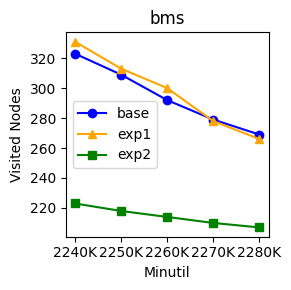

In [ ]:
stat_file = 'EFIM/output/output.stat'
df = pd.read_csv(stat_file, sep="\t\t", engine="python")
fig, axs = plt.subplots(1, 1, figsize=(3, 3))
for idx, dataset in enumerate(df["Dataset"].apply(lambda x: x.split('_')[0]).unique()):
    i, j = int(idx / 3), idx % 3
    for f_type, marker, color in zip(['base', 'exp1', 'exp2'], ['o', '^', 's'], ["blue", "orange", "green"]):
        x = df["Minutil"].where(df["Dataset"] == f"{dataset}_{f_type}").dropna()
        y_runtime = df["Time"].where(df["Dataset"] == f"{dataset}_{f_type}").dropna()
        y_nodes = df["Nodes"].where(df["Dataset"] == f"{dataset}_{f_type}").dropna()

        # Choose y_runtime or y_nodes
        axs.plot(x, y_nodes, label=f_type, marker=marker, color=color, alpha=1)
        axs.set_xticks(x)

    axs.set_title(f"{dataset}")
    axs.legend()
    # axs[i, j].set_yscale('log')
    axs.set_xlabel("Minutil")
    # Choose "Runtime (s)" or "Visited Nodes"
    axs.set_ylabel("Visited Nodes")

    if dataset != "foodmart":
      axs.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x / 1000)}K'))

plt.tight_layout()
plt.show()

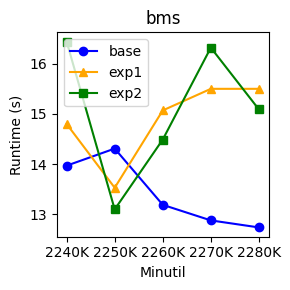

In [ ]:
stat_file = 'EFIM/output/output.stat'
df = pd.read_csv(stat_file, sep="\t\t", engine="python")
fig, axs = plt.subplots(1, 1, figsize=(3, 3))
for idx, dataset in enumerate(df["Dataset"].apply(lambda x: x.split('_')[0]).unique()):
    i, j = int(idx / 3), idx % 3
    for f_type, marker, color in zip(['base', 'exp1', 'exp2'], ['o', '^', 's'], ["blue", "orange", "green"]):
        x = df["Minutil"].where(df["Dataset"] == f"{dataset}_{f_type}").dropna()
        y_runtime = df["Time"].where(df["Dataset"] == f"{dataset}_{f_type}").dropna()
        y_nodes = df["Nodes"].where(df["Dataset"] == f"{dataset}_{f_type}").dropna()

        # Choose y_runtime or y_nodes
        axs.plot(x, y_runtime, label=f_type, marker=marker, color=color, alpha=1)
        axs.set_xticks(x)

    axs.set_title(f"{dataset}")
    axs.legend()
    # axs[i, j].set_yscale('log')
    axs.set_xlabel("Minutil")
    # Choose "Runtime (s)" or "Visited Nodes"
    axs.set_ylabel("Runtime (s)")

    if dataset != "foodmart":
      axs.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x / 1000)}K'))

plt.tight_layout()
plt.show()